In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
import pydicom
import SimpleITK as sitk
from radiomics import featureextractor


def load_dicom_series(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def load_dicom_file(file_path):
    return sitk.ReadImage(file_path)

def resample_image_to_reference(image, reference_image):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference_image)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetTransform(sitk.Transform())
    resampler.SetOutputSpacing(reference_image.GetSpacing())
    resampler.SetSize(reference_image.GetSize())
    resampler.SetOutputDirection(reference_image.GetDirection())
    resampler.SetOutputOrigin(reference_image.GetOrigin())
    return resampler.Execute(image)

paths_df = pd.read_csv('df_patients_nodule_with_diagnose.csv')
paths_df



,Unnamed: 0,Patient,Path_ct,Path_seg,count_noduls_labels,lab_nodul_1,lab_nodul_2
0,64,LIDC-IDRI-0068,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,3.0,-1.0
1,67,LIDC-IDRI-0072,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,1.0,-1.0
2,83,LIDC-IDRI-0088,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,0.0,-1.0
3,85,LIDC-IDRI-0090,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,2.0,-1.0
4,86,LIDC-IDRI-0091,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,3.0,-1.0
...,...,...,...,...,...,...,...
117,813,LIDC-IDRI-0939,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,2.0,-1.0
118,857,LIDC-IDRI-0994,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,2.0,-1.0
119,866,LIDC-IDRI-1004,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,2.0,-1.0
120,872,LIDC-IDRI-1010,G:/Dokumente/MedicalIM/Lung_Cancer/manifest-16...,['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manif...,1,0.0,-1.0


In [2]:

paths_df.drop(columns=['Unnamed: 0'], inplace=True)
paths_df.reset_index(drop=True, inplace=True)


In [3]:
print(len(paths_df["Patient"]))


122


In [4]:
ast.literal_eval(paths_df["Path_seg"][0])

['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/11.000000-Segmentation of Nodule 1 - Annotation Nodule 007-73652',
 'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/13.000000-Segmentation of Nodule 2 - Annotation 5-12739',
 'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/15.000000-Segmentation of Nodule 2 - Annotation 114099-21629',
 'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/17.000000-Segmentation of Nodule 2 - Annotation 134914-42451',
 'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/19.000000-Segmentation of Nodule 2 - Annotation Nodule 001-47156',
 'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232

In [5]:
list_of_seg_paths = []

# Iterate over each row index in the DataFrame
for idx in range(len(paths_df)):
    # Use .iloc to access the "Path_seg" column for each row
    path = paths_df.iloc[idx]["Path_seg"]
    count_noduls_labs = paths_df.iloc[idx]["count_noduls_labels"]
    path_seg1 = ast.literal_eval(path)
    temp = []
    if count_noduls_labs == 1:
        for i in path_seg1:
            if "Nodule 1 " in i:
                files = os.listdir(i)[0]
                path_seg_full = f'{i}/{files}'
                temp.append(path_seg_full)
    elif count_noduls_labs == 2:
        for i in path_seg1:
            if ("Nodule 1 " in i) or ("Nodule 2 " in i):
                files = os.listdir(i)[0]
                path_seg_full = f'{i}/{files}'
                temp.append(path_seg_full)


    list_of_seg_paths.append(temp)

list_of_seg_paths

[['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/11.000000-Segmentation of Nodule 1 - Annotation Nodule 007-73652/1-1.dcm',
  'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/5.000000-Segmentation of Nodule 1 - Annotation 6-15685/1-1.dcm',
  'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/7.000000-Segmentation of Nodule 1 - Annotation 114101-57073/1-1.dcm',
  'G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0068/01-01-2000-NA-CT CHEST W CONT-80168/9.000000-Segmentation of Nodule 1 - Annotation 134918-96427/1-1.dcm'],
 ['G:/Dokumente/MedicalIM/Lung_Cancer_Seg/manifest-1585232716547/LIDC-IDRI/LIDC-IDRI-0072/01-01-2000-NA-CT CHEST W CONT-45499/5.000000-Segmentation of Nodule 1 - Annotation 101448-84524/1-1.dcm',
  'G:/Dokumente/Med

In [6]:
# Initialize feature extractor (assuming you have a params.yaml)
params = 'C:/Users/Gabriel/OneDrive/Dokumente/GitHub/Medical_image/git_extraction/params/qa4iqi_params.yml'
extractor = featureextractor.RadiomicsFeatureExtractor(params)

list_radiomics = []
list_patient_names = []
list_node_names = []
list_labels = []
counter = 0

for ct in range(len(paths_df["Path_ct"])):
    image = load_dicom_series(paths_df["Path_ct"][ct])
    for seg in range(len(list_of_seg_paths[ct])):
        
        ##NAmes and labs
        if "Nodule 1 " in list_of_seg_paths[ct][seg]:
            list_labels.append(paths_df["lab_nodul_1"][ct])
            list_node_names.append(f'Node_N1')  
        elif "Nodule 2 " in list_of_seg_paths[ct][seg]:
            list_labels.append(paths_df["lab_nodul_2"][ct])
            list_node_names.append(f'Node_N2')  

        mask = load_dicom_file(list_of_seg_paths[ct][seg])
        resampled_mask = resample_image_to_reference(mask, image)
        features = extractor.execute(image, resampled_mask, label=255)
        list_patient_names.append(paths_df["Patient"][ct])                  
        list_radiomics.append(features)
    counter += 1    
    print(f'Patient {counter} finished')
#ct_image = load_dicom_series(paths_df["Path_ct"][0])
#mask = load_dicom_file(path_seg_full)

Patient 1 finished
Patient 2 finished
Patient 3 finished
Patient 4 finished
Patient 5 finished
Patient 6 finished
Patient 7 finished
Patient 8 finished
Patient 9 finished
Patient 10 finished
Patient 11 finished
Patient 12 finished
Patient 13 finished
Patient 14 finished
Patient 15 finished
Patient 16 finished
Patient 17 finished
Patient 18 finished
Patient 19 finished
Patient 20 finished
Patient 21 finished
Patient 22 finished
Patient 23 finished
Patient 24 finished
Patient 25 finished
Patient 26 finished
Patient 27 finished
Patient 28 finished
Patient 29 finished
Patient 30 finished
Patient 31 finished
Patient 32 finished
Patient 33 finished
Patient 34 finished
Patient 35 finished
Patient 36 finished
Patient 37 finished
Patient 38 finished
Patient 39 finished
Patient 40 finished
Patient 41 finished
Patient 42 finished
Patient 43 finished
Patient 44 finished
Patient 45 finished
Patient 46 finished
Patient 47 finished
Patient 48 finished
Patient 49 finished
Patient 50 finished
Patient 5

In [7]:
len(list_radiomics)

405

In [8]:
list_radiomics
list_node_names
list_labels

[3.0,
 3.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 1.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 3.0,
 3.0,
 3.0,
 3.0,
 0.0,
 0.0,
 1.0,
 1.0,
 3.0,
 3.0,
 3.0,
 3.0,
 1.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 3.0,
 3.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 1.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 0.0,
 0.0,
 3.0,
 3.0,
 3.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 2.0,
 0.0,
 0.0,
 0.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 3.0,
 3.0,
 0.0,
 0.0

In [9]:
import pandas as pd
from collections import OrderedDict
import json
import numpy as np

# Function to convert OrderedDict to a serializable format
def convert_to_serializable(odict):
    serializable_dict = OrderedDict()
    for key, value in odict.items():
        if isinstance(value, np.ndarray):
            # Convert numpy arrays to lists
            serializable_dict[key] = value.tolist()
        else:
            serializable_dict[key] = value
    return serializable_dict

# Example data - replace this with your actual data
#list_patient_names = ['Patient1', 'Patient2']
#list_node_names = ['Node1', 'Node2']
#list_radiomics = [OrderedDict([('key1', np.array([1, 2, 3])), ('key2', 'value2')]), OrderedDict([('key3', 'value3'), ('key4', np.array([4, 5, 6]))])]

# Convert OrderedDict objects to a serializable format and then to JSON strings
DF_Radiomics = pd.DataFrame({
    "Patient": list_patient_names,
    "Node": list_node_names,
    "Labels": list_labels,
    "Radiomics": [json.dumps(convert_to_serializable(radiomics), ensure_ascii=False) for radiomics in list_radiomics]
})

# Save to CSV
#DF_Radiomics.to_csv("DF_Radiomics_noduls_with_diagnose.csv", index=False)

In [10]:
DF_Radiomics

,Patient,Node,Labels,Radiomics
0,LIDC-IDRI-0068,Node_N1,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
1,LIDC-IDRI-0068,Node_N1,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
2,LIDC-IDRI-0068,Node_N1,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
3,LIDC-IDRI-0068,Node_N1,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
4,LIDC-IDRI-0072,Node_N1,1.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
...,...,...,...,...
400,LIDC-IDRI-1011,Node_N2,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
401,LIDC-IDRI-1011,Node_N1,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
402,LIDC-IDRI-1011,Node_N1,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."
403,LIDC-IDRI-1011,Node_N1,3.0,"{""diagnostics_Versions_PyRadiomics"": ""0+unknow..."


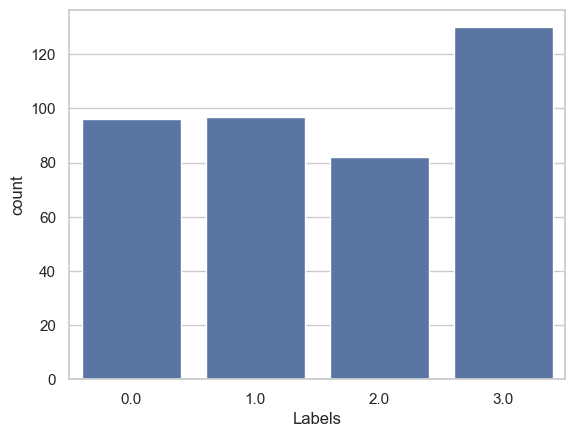

In [17]:
#plot label barplot
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.countplot(x=DF_Radiomics["Labels"]	, data=DF_Radiomics)




In [18]:
DF_Radiomics[DF_Radiomics["Labels"] != 0]

,Patient,Node,Labels,Radiomics
0,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
1,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
2,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
3,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
4,LIDC-IDRI-0072,Node_N1,1.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
...,...,...,...,...
400,LIDC-IDRI-1011,Node_N2,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
401,LIDC-IDRI-1011,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
402,LIDC-IDRI-1011,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
403,LIDC-IDRI-1011,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...


In [20]:


# Load your CSV
DF_Radiomics = pd.read_csv("DF_Radiomics_noduls_with_diagnose.csv")
DF_Radiomics['Radiomics'] = DF_Radiomics['Radiomics'].apply(lambda x: json.loads(x, object_pairs_hook=OrderedDict))
DF_Radiomics

,Patient,Node,Labels,Radiomics
0,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
1,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
2,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
3,LIDC-IDRI-0068,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
4,LIDC-IDRI-0072,Node_N1,1.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
...,...,...,...,...
400,LIDC-IDRI-1011,Node_N2,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
401,LIDC-IDRI-1011,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
402,LIDC-IDRI-1011,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
403,LIDC-IDRI-1011,Node_N1,3.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...


In [23]:


DF_Radiomics[DF_Radiomics["Patient"] == "LIDC-IDRI-0203"]

,Patient,Node,Labels,Radiomics
132,LIDC-IDRI-0203,Node_N1,2.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
133,LIDC-IDRI-0203,Node_N2,0.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
134,LIDC-IDRI-0203,Node_N2,0.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
135,LIDC-IDRI-0203,Node_N2,0.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
136,LIDC-IDRI-0203,Node_N2,0.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
137,LIDC-IDRI-0203,Node_N1,2.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
138,LIDC-IDRI-0203,Node_N1,2.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...
139,LIDC-IDRI-0203,Node_N1,2.0,{'diagnostics_Versions_PyRadiomics': '0+unknow...


In [21]:
for feature_name, feature_value in DF_Radiomics['Radiomics'][0].items():
    print(f"{feature_name}: {feature_value}")

diagnostics_Versions_PyRadiomics: 0+unknown
diagnostics_Versions_Numpy: 1.26.2
diagnostics_Versions_SimpleITK: 2.1.1.2
diagnostics_Versions_PyWavelet: 1.2.0
diagnostics_Versions_Python: 3.10.13
diagnostics_Configuration_Settings: OrderedDict([('minimumROIDimensions', 2), ('minimumROISize', None), ('normalize', False), ('normalizeScale', 1), ('removeOutliers', None), ('resampledPixelSpacing', None), ('interpolator', 'sitkBSpline'), ('preCrop', False), ('padDistance', 5), ('distances', [1]), ('force2D', False), ('force2Ddimension', 0), ('resegmentRange', None), ('label', 255), ('additionalInfo', True), ('binWidth', 25), ('weightingNorm', None)])
diagnostics_Configuration_EnabledImageTypes: OrderedDict([('Original', OrderedDict())])
diagnostics_Image-original_Hash: bea2c9750ea59a0bebb6d3bd63ffacc40fcf6a28
diagnostics_Image-original_Dimensionality: 3D
diagnostics_Image-original_Spacing: [0.683594, 0.683594, 1.25]
diagnostics_Image-original_Size: [512, 512, 261]
diagnostics_Image-original_M